## Using information theory to evaluate features

The mutual information (MI) between a feature and the outcome is a measure of the mutual dependence between the two variables. It extends the notion of correlation to nonlinear relationships. More specifically, it quantifies the information obtained about one random variable through the other random variable.

The concept of MI is closely related to the fundamental notion of entropy of a random variable. Entropy quantifies the amount of information contained in a random variable. Formally, the mutual information—I(X, Y)—of two random variables, X and Y, is defined as the following:

The sklearn function implements feature_selection.mutual_info_regression that computes the mutual information between all features and a continuous outcome to select the features that are most likely to contain predictive information. There is also a classification version (see the documentation for more details). 

This notebook contains an application to the financial data we created in Chapter 4, Alpha Factor Research.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_classif

In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

## Get Data

We use the data produced in [Chapter 4](../../04_alpha_factor_research/00_data/feature_engineering.ipynb).


In [4]:
with pd.HDFStore(r'D:\科研课题\assets.h5') as store:
    data = store['engineered_features']

In [5]:
data

return_1m  return_2m  return_3m  return_6m  return_9m  \
ticker date                                                                
A      2001-01-31  -0.003653   0.022360   0.056104   0.049811  -0.052500   
       2001-02-28  -0.329564  -0.189115  -0.116435  -0.084141  -0.076425   
       2001-03-31  -0.146389  -0.249443  -0.175116  -0.074628  -0.092690   
       2001-04-30   0.269444   0.040966  -0.105747  -0.028185  -0.004837   
       2001-05-31  -0.140220   0.044721  -0.023317  -0.071042  -0.064299   
...                      ...        ...        ...        ...        ...   
ZUMZ   2017-10-31  -0.024862   0.190660   0.115956  -0.002805  -0.014066   
       2017-11-30   0.235127   0.097461   0.205302   0.073430   0.007402   
       2017-12-31  -0.044725   0.086226   0.047857   0.090987   0.014465   
       2018-01-31  -0.003601  -0.024380   0.055418   0.085265   0.016237   
       2018-02-28  -0.050602  -0.027386  -0.033200   0.079484   0.036640   

                   return_12m    Mkt-RF       SMB       HML       RMW  ...  \
ticker date                                                            ...   
A      2001-01-31   -0.015988  1.262244  0.577416 -0.677951 -1.241935  ...   
       2001-02-28   -0.084537  1.262244  0.577416 -0.677951 -1.241935  ...   
       2001-03-31   -0.096606  1.262244  0.577416 -0.677951 -1.241935  ...   
       2001-04-30   -0.066102  1.262244  0.577416 -0.677951 -1.241935  ...   
       2001-05-31   -0.063425  1.262244  0.577416 -0.677951 -1.241935  ...   
...                       ...       ...       ...       ...       ...  ...   
ZUMZ   2017-10-31   -0.019115  0.120511  0.281107  1.057092  2.593258  ...   
       2017-11-30   -0.010687 -0.768395  0.998015  1.349890  2.950637  ...   
       2017-12-31   -0.003996 -0.766557  1.325263  1.322945  3.462953  ...   
       2018-01-31    0.002864 -0.958808  1.658193  1.523229  3.646938  ...   
       2018-02-28   -0.002905  0.075697  1.161659  1.317316  2.983589  ...   

                   return_1m_t-5  return_1m_t-6  target_1m  target_2m  \
ticker date                                                             
A      2001-01-31            NaN            NaN  -0.329564  -0.249443   
       2001-02-28            NaN            NaN  -0.146389   0.040966   
       2001-03-31            NaN            NaN   0.269444   0.044721   
       2001-04-30            NaN            NaN  -0.140220  -0.087246   
       2001-05-31            NaN            NaN  -0.031008  -0.076414   
...                          ...            ...        ...        ...   
ZUMZ   2017-10-31      -0.206128      -0.019126   0.235127   0.086226   
       2017-11-30      -0.133333      -0.206128  -0.044725  -0.024380   
       2017-12-31       0.028340      -0.133333  -0.003601  -0.027386   
       2018-01-31      -0.019685       0.028340  -0.050602   0.066466   
       2018-02-28       0.430943      -0.019685   0.197970        NaN   

                   target_3m  target_6m  target_12m  age  msize  \
ticker date                                                       
A      2001-01-31  -0.105747  -0.101978   -0.047686    2   10.0   
       2001-02-28  -0.023317  -0.049781   -0.011986    2    9.0   
       2001-03-31   0.018842  -0.072607    0.010805    2    9.0   
       2001-04-30  -0.098192  -0.089198   -0.021512    2    9.0   
       2001-05-31  -0.075527  -0.033904   -0.019843    2    9.0   
...                      ...        ...         ...  ...    ...   
ZUMZ   2017-10-31   0.055418        NaN         NaN    3    2.0   
       2017-11-30  -0.033200        NaN         NaN    3    2.0   
       2017-12-31   0.042579        NaN         NaN    3    2.0   
       2018-01-31        NaN        NaN         NaN    3    2.0   
       2018-02-28        NaN        NaN         NaN    3    2.0   

                              sector  
ticker date                           
A      2001-01-31      Capital Goods  
       2001-02-28      Capital Goods  
       2001-03-31      Capital Goods 

## Create Dummy variables

In [6]:
dummy_data = pd.get_dummies(data,
                            columns=['year','month', 'msize', 'age', 'sector'],
                            prefix=['year','month', 'msize', 'age', ''],
                            prefix_sep=['_', '_', '_', '_', ''])
#哑变量变换get_dummies，抽出原data中的columns项，并形成特征距离
dummy_data = dummy_data.rename(columns={c:c.replace('.0', '') for c in dummy_data.columns}) #调整一下列的名称
dummy_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 358914 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-02-28 00:00:00'))
Data columns (total 88 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   return_1m              358914 non-null  float64
 1   return_2m              358914 non-null  float64
 2   return_3m              358914 non-null  float64
 3   return_6m              358914 non-null  float64
 4   return_9m              358914 non-null  float64
 5   return_12m             358914 non-null  float64
 6   Mkt-RF                 358914 non-null  float64
 7   SMB                    358914 non-null  float64
 8   HML                    358914 non-null  float64
 9   RMW                    358914 non-null  float64
 10  CMA                    358914 non-null  float64
 11  momentum_2             358914 non-null  float64
 12  momentum_3             358914 non-null  float64
 13  momentum_6     

## Mutual Information

### Original Data

In [7]:
target_labels = [f'target_{i}m' for i in [1,2,3,6,12]]
targets = data.dropna().loc[:, target_labels]  #抽出所有target_labels列

features = data.dropna().drop(target_labels, axis=1)
#print(features.sector)
features.sector = pd.factorize(features.sector)[0] #对sector重新编码
#print(features.sector)

cat_cols = ['year', 'month', 'msize', 'age', 'sector']
discrete_features = [features.columns.get_loc(c) for c in cat_cols] #找到cat_cols中这些值为离散值的列的位置

In [8]:
mutual_info = pd.DataFrame()
for label in target_labels: #mutual_info_classif计算离散目标变量与特征矩阵的互信息
    mi = mutual_info_classif(X=features, 
                             y=(targets[label]> 0).astype(int), #把target大于0转化为1，小于等于0转化为0。当y是离散值时，用mutual_info_classif，若y是连续值，则用mutual_info_regression
                             discrete_features=discrete_features, #指明这些列是离散值
                             random_state=42
                            )
    mutual_info[label] = pd.Series(mi, index=features.columns)

In [9]:
mutual_info.sum() #所有特征的互信息之和

target_1m     0.034596
target_2m     0.057843
target_3m     0.091083
target_6m     0.133638
target_12m    0.199559
dtype: float64

### Normalized MI Heatmap

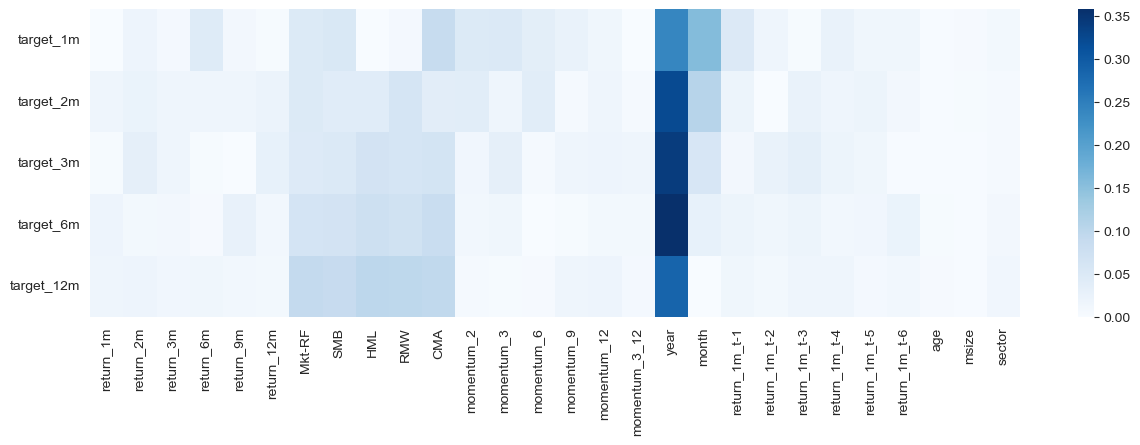

In [10]:
fig, ax= plt.subplots(figsize=(15, 4))
sns.heatmap(mutual_info.div(mutual_info.sum()).T, ax=ax, cmap='Blues');
#mutual_info.div(mutual_info.sum())意味着每一列都[0,1]标准化

### Dummy Data

In [11]:
target_labels = [f'target_{i}m' for i in [1, 2, 3, 6, 12]]
dummy_targets = dummy_data.dropna().loc[:, target_labels]

dummy_features = dummy_data.dropna().drop(target_labels, axis=1)
cat_cols = [c for c in dummy_features.columns if c not in features.columns] #把后来增加的离散值的列找出来
discrete_features = [dummy_features.columns.get_loc(c) for c in cat_cols]

In [12]:
mutual_info_dummies = pd.DataFrame()
for label in target_labels:
    mi = mutual_info_classif(X=dummy_features, 
                             y=(dummy_targets[label]> 0).astype(int),
                             discrete_features=discrete_features,
                             random_state=42
                            )    
    mutual_info_dummies[label] = pd.Series(mi, index=dummy_features.columns)

In [13]:
mutual_info_dummies.sum()

target_1m     0.035736
target_2m     0.059774
target_3m     0.093789
target_6m     0.137612
target_12m    0.204292
dtype: float64

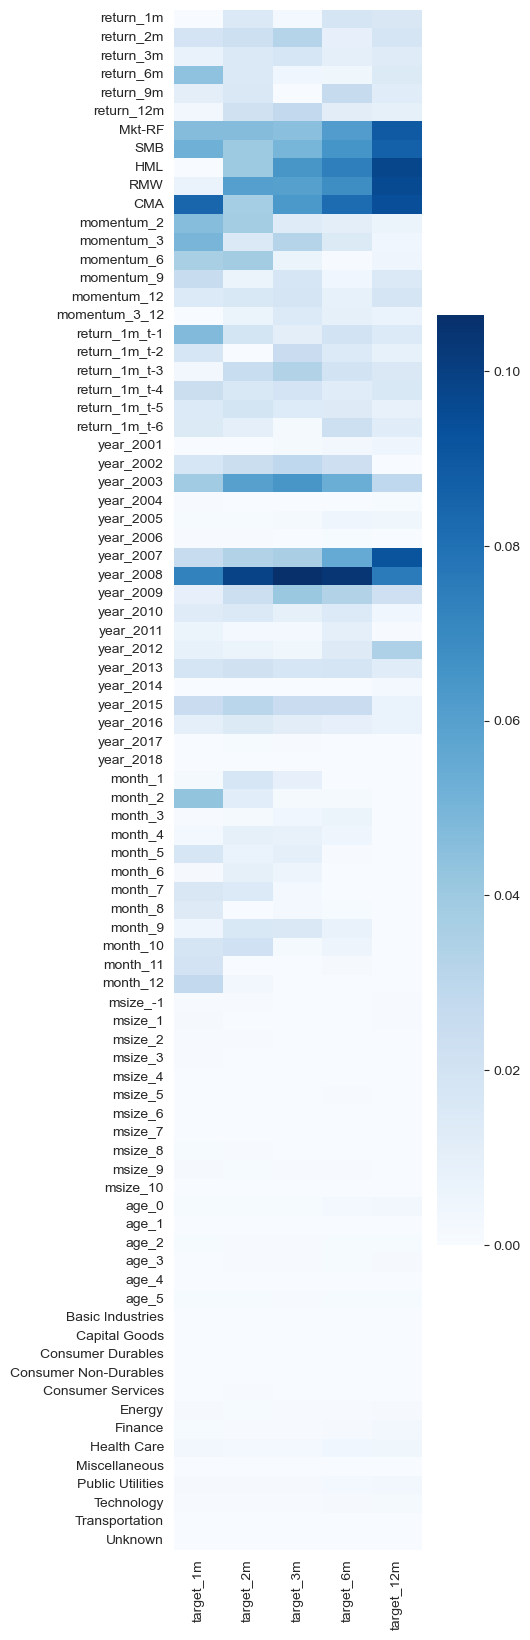

In [14]:
fig, ax= plt.subplots(figsize=(4, 20))
sns.heatmap(mutual_info_dummies.div(mutual_info_dummies.sum()), ax=ax, cmap='Blues');